# Fig S8 of SI

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
df_multi now has networks: ['ring' 'bipartite' 'complete' 'custom' 'empirical']
df_single now has networks: ['ring' 'custom' 'bipartite' 'complete' 'empirical']


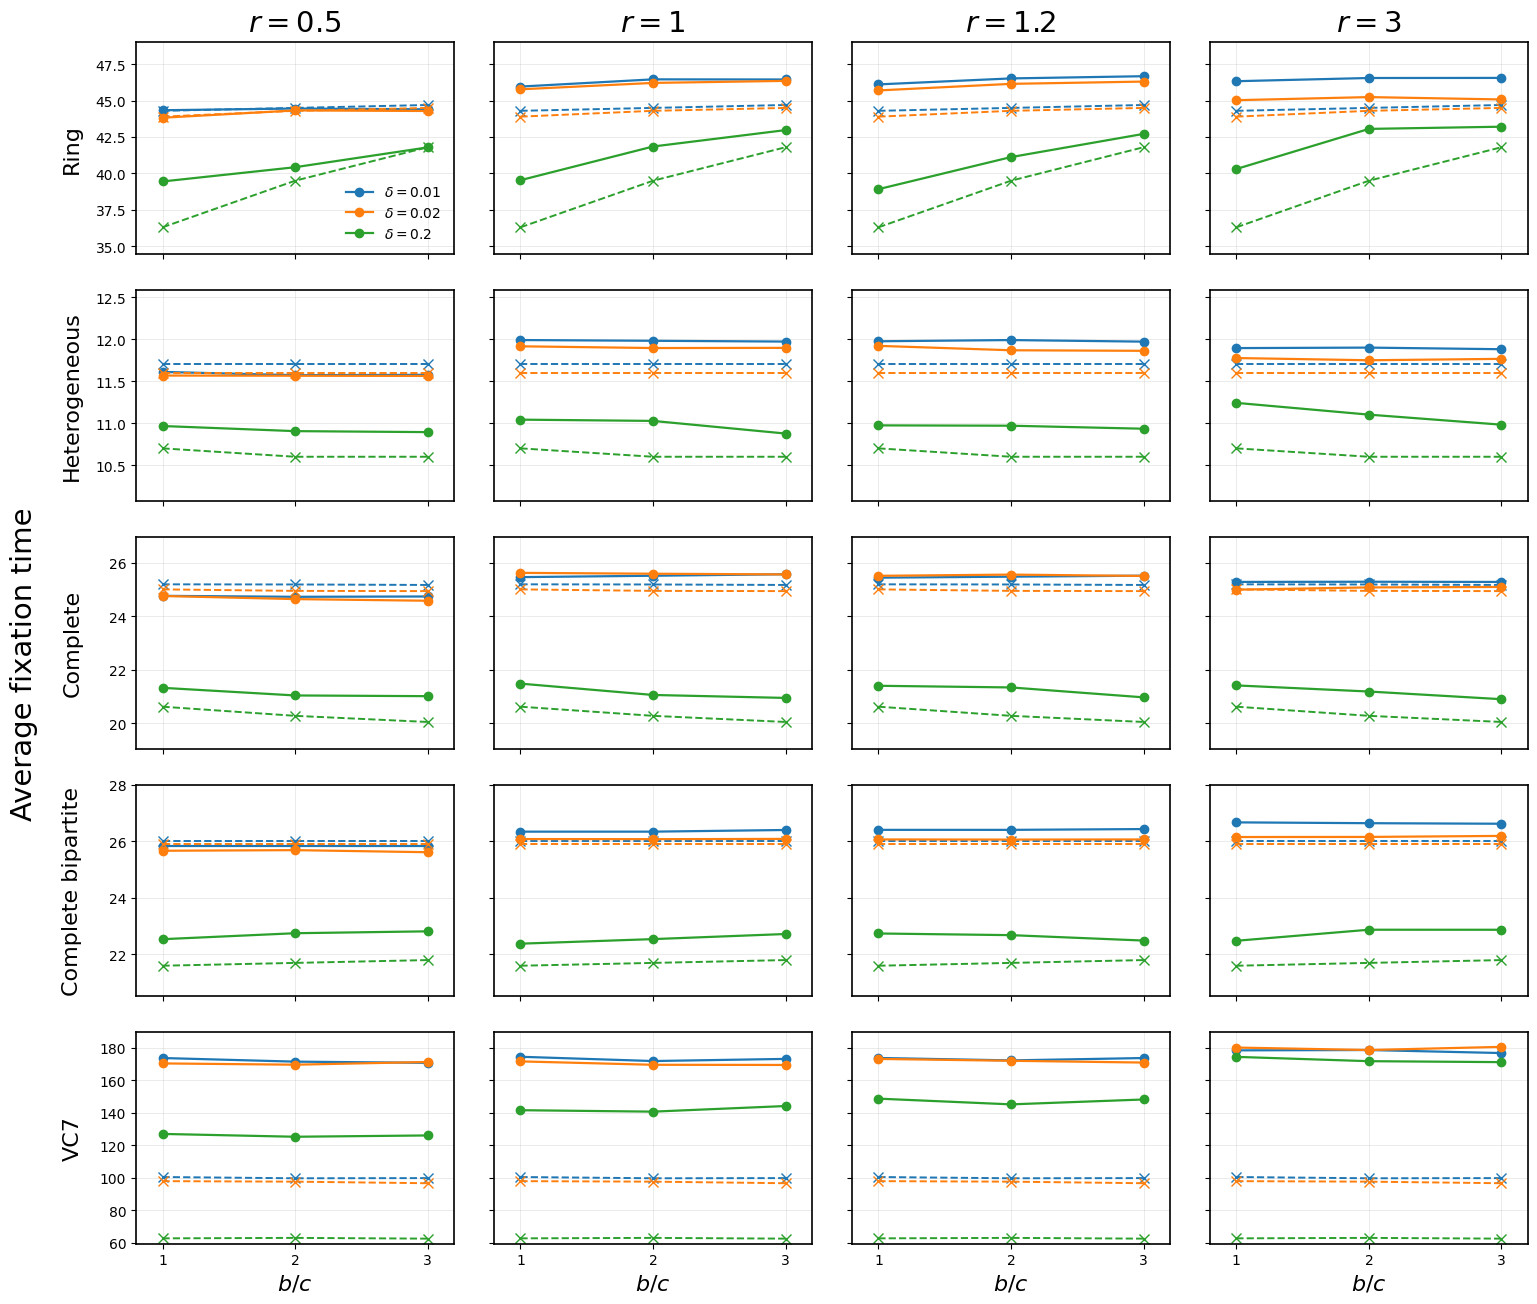

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
df_single = pd.read_csv("single_layer_sim_results.csv")
# -------------------------------------------------------------------
# 2) Load multilayer dataframe & keep the game-layer fixation time
# -------------------------------------------------------------------
multi_csv = Path("multilayer_network_comparison_sweep.csv")
if not multi_csv.exists():
    raise FileNotFoundError("Run your multilayer sweep first, so the CSV is present!")

df_multi = pd.read_csv(multi_csv)
# keep only what we need and rename for clarity
df_multi = (df_multi[["network", "b", "delta", "r", "avg_game_fix"]]
            .rename(columns={"avg_game_fix": "tau"}))
# Load empirical multilayer results
df_emp_multi = pd.read_csv("empirical_multilayer_results.csv")
df_emp_multi = df_emp_multi.rename(columns={"avg_time_all": "tau"})
df_emp_multi["network"] = "empirical"
# Keep only needed columns
df_emp_multi = df_emp_multi[["network", "b", "r", "delta", "tau"]]

# Load empirical single-layer (game) results
df_emp_single = pd.read_csv("empirical_single_game_results.csv")
df_emp_single = df_emp_single.rename(columns={"avg_time": "tau"})
df_emp_single["network"] = "empirical"
# Keep only needed columns
df_emp_single = df_emp_single[["network", "b", "delta", "tau"]]

# Merge with existing dataframes
df_multi = pd.concat([df_multi, df_emp_multi], ignore_index=True)
df_single = pd.concat([df_single, df_emp_single], ignore_index=True)

print(f"df_multi now has networks: {df_multi['network'].unique()}")
print(f"df_single now has networks: {df_single['network'].unique()}")


# df_single and df_multi are assumed to be present in memory
# ----------------------------------------------------------------
# Normalize names once (custom -> heterogenous)
df_single = df_single.replace({"network": {"custom": "heterogenous"}})
df_multi  = df_multi.replace({"network": {"custom": "heterogenous"}})

# Aggregate duplicates by averaging
df_multi = df_multi.groupby(["network", "b", "r", "delta"], as_index=False)["tau"].mean()
df_single = df_single.groupby(["network", "b", "delta"], as_index=False)["tau"].mean()

# Add mapping - now includes empirical as 5th row
networks = ["ring", "heterogenous", "complete", "bipartite", "empirical"]
net_map  = {
    "ring": "Ring",
    "heterogenous": "Heterogeneous",
    "bipartite": "Complete bipartite",
    "complete": "Complete",
    "empirical": "VC7"
}

# r values - using 0.5, 1, 1.2, 3 (integers where appropriate)
r_values   = [0.5, 1.0, 1.2, 3.0]
# Use union so we cover deltas present only in single-layer (if any)
delta_vals = sorted(set(df_multi["delta"].unique()).union(df_single["delta"].unique()))
colors     = {0.01: "#1f77b4", 0.02: "#ff7f0e", 0.2: "#2ca02c"}

# Create figure with 5 rows now (added one for empirical)
fig, axes = plt.subplots(len(networks), len(r_values),
                         figsize=(16, 13.5), sharex=True, sharey="row")

for row, net in enumerate(networks):
    axrow = axes[row]
    single_net = df_single[df_single["network"] == net]
    multi_net  = df_multi[df_multi["network"] == net]
    
    # y-range per row (fallback if multi is empty)
    if not single_net.empty or not multi_net.empty:
        row_data = pd.concat([single_net[["tau"]], multi_net[["tau"]]], ignore_index=True)
        y_min, y_max = row_data["tau"].min()*0.95, row_data["tau"].max()*1.05
    else:
        # Shouldn't happen, but guard anyway
        y_min, y_max = 0.0, 1.0
    
    for col, r in enumerate(r_values):
        ax = axrow[col]
        multi_sub = multi_net[multi_net["r"] == r]
        
        for k, delta in enumerate(delta_vals):
            # multilayer (solid) — only if present
            mline = multi_sub[multi_sub["delta"] == delta].sort_values("b")
            if not mline.empty:
                ax.plot(mline["b"], mline["tau"],
                        color=colors.get(delta, "0.5"),
                        marker="o", linewidth=1.6,
                        label=rf"$\delta={delta:g}$" if (row == 0 and col == 0) else None)
            
            # single-layer baseline (dashed, X) — always if present
            sline = single_net[single_net["delta"] == delta].sort_values("b")
            if not sline.empty:
                ax.plot(sline["b"], sline["tau"],
                        color=colors.get(delta, "0.5"),
                        linestyle="--", marker="x",
                        markersize=7, linewidth=1.4)
        
        # cosmetics
        ax.set_xlim(0.8, 3.2)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels([1, 2, 3])
        ax.grid(alpha=0.25, linewidth=0.7)
        
        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
        
        # Column titles (r values) - only on top row
        if row == 0:
            r_display = int(r) if r == int(r) else r
            ax.set_title(rf"$r={r_display}$", fontsize=21, pad=8, fontweight='bold')
        
        # Row labels (network types) - only on leftmost column, NO bold, 1.2x bigger
        if col == 0:
            ax.text(-0.20, 0.5, net_map[net], 
                   transform=ax.transAxes,
                   fontsize=16,  # 13 * 1.2 ≈ 16
                   ha='center', va='center',
                   rotation=90)
        
        # x-label below each column (bottom row only)
        if row == len(networks) - 1:
            ax.set_xlabel(r"$b/c$", fontsize=16)
        
        # Optional: annotate if this panel has no multilayer data
        if multi_sub.empty:
            ax.text(0.99, 0.02, "no multilayer",
                    ha="right", va="bottom", transform=ax.transAxes,
                    fontsize=8, color="0.4")

# Single legend with better styling
axes[0, 0].legend(frameon=False, fontsize=10, loc='lower right')

# Add common y-label - NO bold, same size as r titles (21), moved closer to figure
fig.text(0.04, 0.5, "Average fixation time", ha="center", va="center", 
         rotation="vertical", fontsize=21)

plt.subplots_adjust(left=0.11, right=0.98, top=0.96, bottom=0.07, 
                   hspace=0.17, wspace=0.125)

plt.savefig("fixation_time.png", dpi=300, bbox_inches='tight')

plt.show()